In [15]:
import geopandas as gpd
import pandas as pd
import numpy as np
import networkx as nx
from pathlib import Path
import re

import matplotlib.pyplot as plt
import folium


NODE_GEO_PATH = "neena_nodes.geojson"
EDGE_GEO_PATH = "neena_edges.geojson"
EDGE_ATTR_PATH = "neena_linked_table.txt"
ROUTE_PATH = "neena_route.txt"
BASELINE_PATH = "baseline_route.txt"

# Read Node List and Edge List
node_gdf = gpd.read_file(NODE_GEO_PATH)
node_gdf.set_index('id', inplace=True)
edge_gdf = gpd.read_file(EDGE_GEO_PATH)
edge_gdf.id = edge_gdf.id - 1 # transform to starts from 0
edge_gdf['EID'] = edge_gdf.id # copy id to field EID
edge_gdf.set_index('id', inplace=True)

edge_df = pd.read_csv(EDGE_ATTR_PATH, index_col=None, header=None, delim_whitespace=True)
edge_df = edge_df.rename(columns={0:'s',1:'t',2:'length',3:'priority',4:'weight'})
edge_df.s= edge_df.s.astype(np.int64)
edge_df.t= edge_df.t.astype(np.int64)
edge_gdf = edge_gdf.join(edge_df, on='id', how='left', lsuffix='_left', rsuffix='_right')

print(edge_gdf.head())

def read_route(route_path):
  route_pattern = re.compile("ID: (\d+) --- (\d+)->(\d+)")
  route_list = []
  for l in Path(route_path).read_text().splitlines():
    m = route_pattern.match(l)
    if m is None:
      continue
    edge_id = int(m.group(1)) - 1
    s = int(m.group(2))
    t = int(m.group(3))
    # if s != edge_gdf.loc[edge_id].s or t != edge_gdf.loc[edge_id].t:
    #   print(f"Warning: edge{edge_id} and route not match: {s}!={edge_gdf.loc[edge_id].s} or {t}!={edge_gdf.loc[edge_id].t}")
    route_list.append(edge_id)
  return route_list

neena_route = read_route(ROUTE_PATH)
baseline_route = read_route(BASELINE_PATH)
print(f"Load {len(neena_route)} routes (neena)")
print(f"Load {len(baseline_route)} routes (baseline)")

                                              geometry  EID  s   t  length  \
id                                                                           
117  MULTILINESTRING ((-83.09613 40.19323, -83.0964...  117  4  24     0.3   
0    MULTILINESTRING ((-83.09649 40.18002, -83.0966...    0  0   1     0.3   
1    MULTILINESTRING ((-83.09751 40.18403, -83.0975...    1  1   2     0.3   
2    MULTILINESTRING ((-83.09669 40.18814, -83.0964...    2  2   3     0.2   
3    MULTILINESTRING ((-83.09563 40.19087, -83.0956...    3  3   4     0.2   

     priority  weight  
id                     
117         1   0.300  
0           4   0.075  
1           4   0.075  
2           4   0.050  
3           4   0.050  
Load 172 routes (neena)
Load 237 routes (baseline)


# Analysis 1

Compare the total traveling distance between baseline and our route.

In [74]:
baseline_total_distance = np.sum([ edge_gdf.loc[eid,'length'] for eid in baseline_route])
neena_total_distance = np.sum([ edge_gdf.loc[eid,'length'] for eid in neena_route])
print(f"Baseline route total distance: {baseline_total_distance} miles")
print(f"Our route total distance: {neena_total_distance} miles")
print("Saved {:.2f}%".format((baseline_total_distance - neena_total_distance) / baseline_total_distance * 100))

Baseline route total distance: 31.580000000000005 miles
Our route total distance: 21.71 miles
Saved 31.25%


# Analysis 2 Visualize traveled times on each road segment. 

We assume cleaning only need one travel on the road segment. Multiple traveling is waste of time and gas.

In [76]:
from itertools import repeat
baseline_visits = dict(zip(edge_gdf.index, repeat(0)))
neena_visits = dict(zip(edge_gdf.index, repeat(0)))

baseline_visits.update(dict(zip(*np.unique(baseline_route,return_counts=True))))
neena_visits.update(dict(zip(*np.unique(neena_route,return_counts=True))))

edge_gdf['Baseline_visits'] = baseline_visits
edge_gdf['Our_visits'] = neena_visits


In [78]:
m = None
edge_max_count = max(edge_gdf['Baseline_visits'].max(), edge_gdf['Our_visits'].max())
m = edge_gdf.explore(m=m, name="Baseline_visits", tooltip=['Baseline_visits', 'Our_visits'], column="Baseline_visits", cmap="viridis", vmax=edge_max_count, legend=True, style_kwds={"weight": 10, 'alpha': 0.9})
m = edge_gdf.explore(m=m, name="Our visits", tooltip=['Baseline_visits', 'Our_visits'], column="Our_visits", cmap="viridis", vmax=edge_max_count, legend=True, style_kwds={"weight": 10, 'alpha': 0.9})
folium.LayerControl(collapsed=False).add_to(m)
m

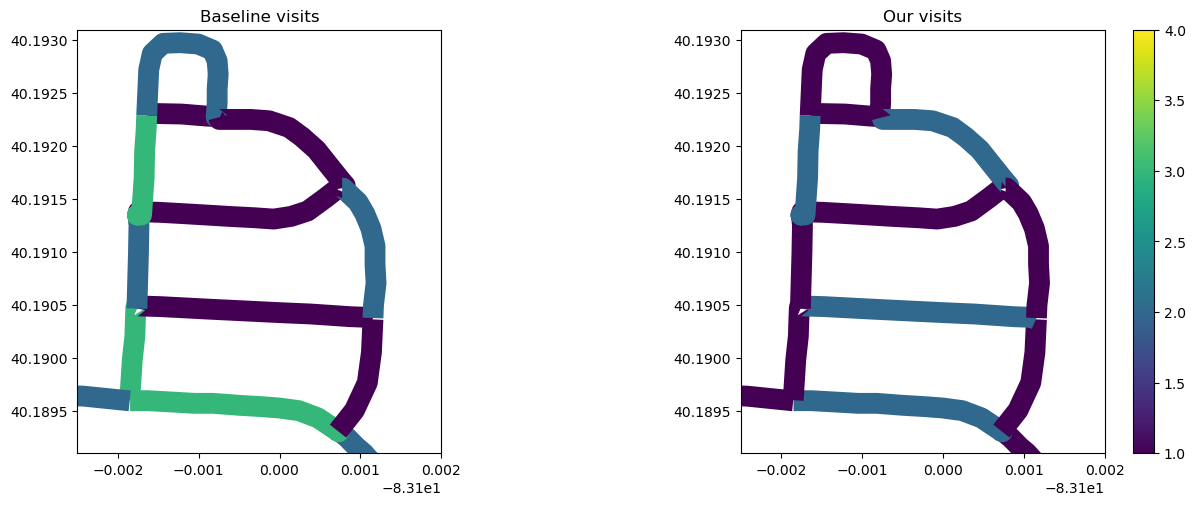

In [168]:
fig, ax = plt.subplots(1,2,figsize=(16, 5.5))
ax[0].set_xlim(-83.1025,-83.098)
ax[0].set_ylim(40.1891, 40.1931)
ax[1].set_xlim(-83.1025,-83.098)
ax[1].set_ylim(40.1891, 40.1931)
edge_gdf.plot(ax=ax[0], column="Baseline_visits", cmap="viridis", vmax=edge_max_count, linewidth=15)
ax[0].set_title("Baseline visits")
edge_gdf.plot(ax=ax[1], column="Our_visits", cmap="viridis", vmax=edge_max_count, legend=True, linewidth=15)
ax[1].set_title("Our visits")
plt.show()

# Analysis 3 Animation of the route


MovieWriter ffmpeg unavailable; using Pillow instead.


Done


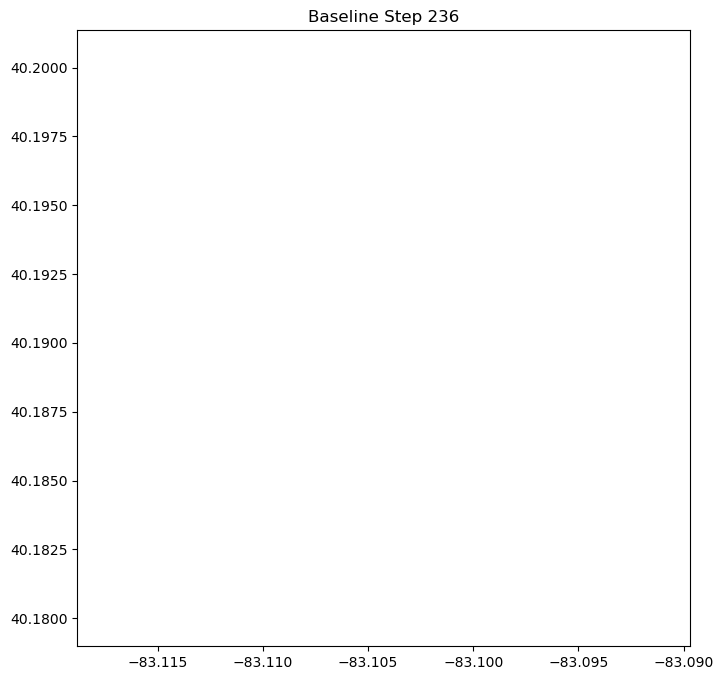

In [166]:
from celluloid import Camera

xmin, ymin, xmax, ymax = edge_gdf.total_bounds
xmin -= 0.001
ymin -= 0.001
xmax += 0.001
ymax += 0.001
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_aspect('equal','box')


camera = Camera(fig)

for step in range(1, len(baseline_route)):
    step_route = baseline_route[:step]
    _edges, _count = np.unique(step_route, return_counts=True)
    
    step_gdf = edge_gdf.loc[_edges].copy()
        
    step_gdf.plot(ax=ax, linewidth=5)
    step_gdf.loc[[step_route[-1]]].plot(ax=ax, color='red', linewidth=5)
    ax.set_title(f"Baseline Step {step}")
    camera.snap()

anim = camera.animate()
anim.save('baseline_route.gif')
print('Done')

MovieWriter ffmpeg unavailable; using Pillow instead.


Done


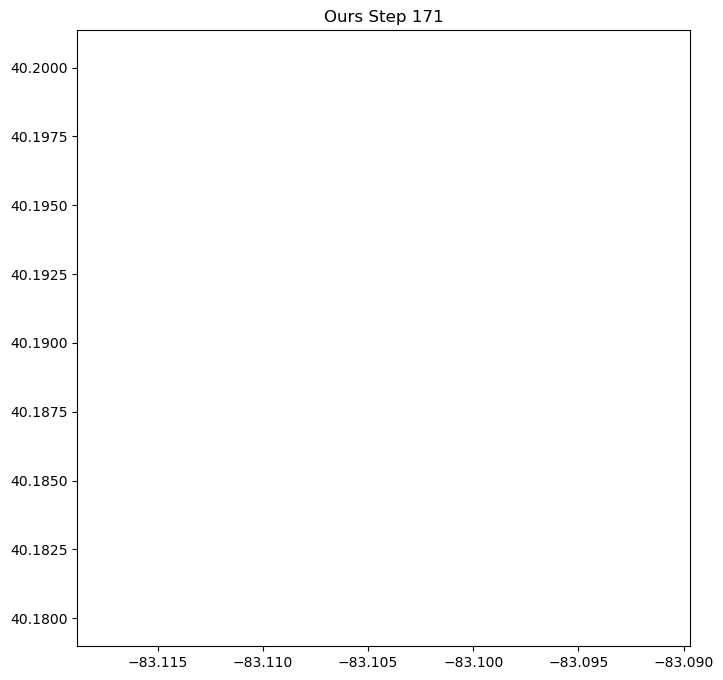

In [167]:
from celluloid import Camera

xmin, ymin, xmax, ymax = edge_gdf.total_bounds
xmin -= 0.001
ymin -= 0.001
xmax += 0.001
ymax += 0.001
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_aspect('equal','box')


camera = Camera(fig)

for step in range(1, len(neena_route)):
    step_route = neena_route[:step]
    _edges, _count = np.unique(step_route, return_counts=True)
    
    step_gdf = edge_gdf.loc[_edges].copy()
        
    step_gdf.plot(ax=ax, linewidth=5)
    step_gdf.loc[[step_route[-1]]].plot(ax=ax, color='red', linewidth=5)
    ax.set_title(f"Ours Step {step}")
    camera.snap()

anim = camera.animate()
anim.save('neena_route.gif')
print('Done')

# Backups

In [ ]:

# create graph based on edge_gdf
G = nx.from_pandas_edgelist(edge_gdf, 's', 't', ['EID', 'weight', 'length', 'priority'], create_using=nx.Graph())
nx.set_node_attributes(G, node_gdf['geometry'].apply(lambda pt:(pt.x, pt.y)).to_dict(), 'pos')

plt.figure(figsize=(8,4))
plt.title(f"Topological Road Network of Neena")
nx.draw(G, pos=nx.get_node_attributes(G, 'pos'), node_size=10)


In [ ]:
m = None
m = node_gdf.explore(m=m, name="Nodes")
m = edge_gdf.explore(m=m, name="Roads")

folium.LayerControl(collapsed=False).add_to(m)
m